---

##  2.3 策略迭代法的实现

- `策略迭代法`：

   在根据策略行动最终到达目标时，那种更快到达目标的策略下所执行的动作（action）是更重要的，可以对策略进行更新，以后更多地采用这一行动。换句话说，这是一项强调成功案例动作的行动方案.
- `价值迭代法`：

   从目标反向计算在目标的前一步、前两步的位置（状态）等，一步步引导智能体的行为。换句话说，它是一种给目标以外的位置（状态）也附加价值（优先级）的行动方案。

### 2.3.1 `策略迭代法`与`价值迭代法`

`策略梯度法`（policy gradient method）是`策略迭代法`的一种具体算法。

`softmax函数`是机器学习、深度学习中经常使用的函数：

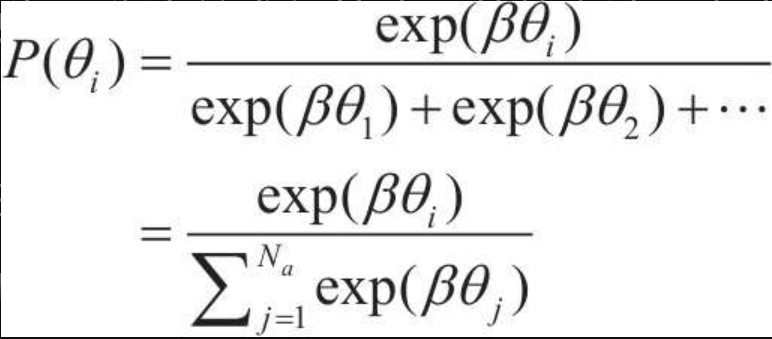

其中`Na`表示可以选择的动作类型的总数。

---

### 2.3.2 根据`策略梯度法`移动智能体

In [20]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

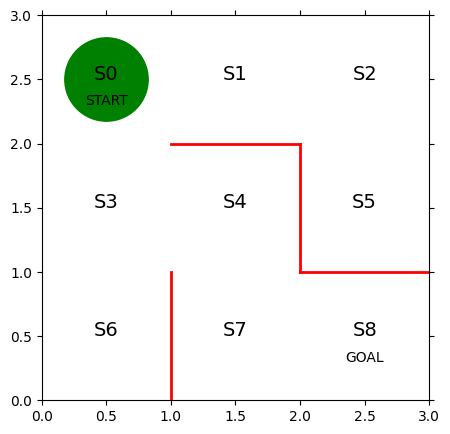

In [21]:
# 声明图的大小及图的变量名
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 画出红色的墙壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 画出表示状态的文字 S0~S8
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 设定画图的范围
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 当前位置S0用绿色圆圈画出
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [22]:
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8是目标
                    ])

前三个代码片段与之前相同。

以下计算比率的代码片段从简单计算比率改成利用exp的softmax函数。

In [23]:
def softmax_convert_into_pi_from_theta(theta):
    '''根据softmax函数计算比率'''

    beta = 1.0
    [m, n] = theta.shape  # 求得theta的矩阵大小
    pi = np.zeros((m, n))

    exp_theta = np.exp(beta * theta)  # 将theta转换为exp(theta)
    for i in range(0, m):
        # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
        # 简单地计算比率

        pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])
        # 用softmax计算比率

    pi = np.nan_to_num(pi)  # nan转换为0

    return pi

In [24]:
# 求得初始策略pi_0
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [25]:
# 定义求取动作a以及1步移动后的状态s的函数

def get_action_and_next_s(pi, s):
    direction = ["up", "right", "down", "left"]
    # 根据概率pi[s,:]选择direction
    next_direction = np.random.choice(direction, p=pi[s, :])

    if next_direction == "up":
        action = 0
        s_next = s - 3  # 向上移动时状态的数字减少3
    elif next_direction == "right":
        action = 1
        s_next = s + 1  # 向右移动时状态的数字增加1
    elif next_direction == "down":
        action = 2
        s_next = s + 3  # 向下移动时状态的数字增加3
    elif next_direction == "left":
        action = 3
        s_next = s - 1  # 向左移动时状态的数字减少1

    return [action, s_next]

In [26]:
# 定义求解迷宫问题的函数，它输出状态和动作


def goal_maze_ret_s_a(pi):
    s = 0  # 开始地点
    s_a_history = [[0, np.nan]]  # 记录智能体移动的列表

    while (1):  # 直至达到目标的路径
        [action, next_s] = get_action_and_next_s(pi, s)
        s_a_history[-1][1] = action
        # 代入当前状态(即目前最后一个状态idnex=-1)的动作

        s_a_history.append([next_s, np.nan])
        # 代入下一个状态，由于还不知道其动作，用nan表示

        if next_s == 8:  # 达到目标地点则终止
            break
        else:
            s = next_s

    return s_a_history

In [27]:
# 在迷宫内朝目标移动
state_history = goal_maze_ret_s_a(pi_0)

print(state_history)
print("求解迷宫路径所需的步骤是 " + str(len(state_history) - 1))

[[0, 2], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 2], [3, 0], [0, 1], [1, 3], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 1], [4, 3], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
求解迷宫路径所需的步骤是 50


---

### 2.3.3 根据`策略梯度法`更新策略